# Modelos usando el algoritmo de vecinos más cercanos (KNN)

### Importación de bibliotecas

In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.model_selection import train_test_split
import sklearn as skl

from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import RandomizedSearchCV

import pandas as pd
import numpy as np
import preprocessing
import informe

In [2]:
GSPREADHSEET_DOWNLOAD_URL = (
    "https://docs.google.com/spreadsheets/d/{gid}/export?format=csv&id={gid}".format
)

FIUFIP_2021_1_GID = '1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0'
df = pd.read_csv(GSPREADHSEET_DOWNLOAD_URL(gid=FIUFIP_2021_1_GID))

### Llamado a funciones de preprocesamiento
- Dada la alta complejidad espacial del algortimo de knn, se realizará el entrenamiento con el 15% de los datos y las validaciones con el 85% 
- Del dataset de validación se separará una porción para el test final.

In [3]:
df = preprocessing.remove_irrelevant_features(df)
df = preprocessing.missings_treatment(df)
df = preprocessing.one_hot_encoding(df)
X = df.drop('tiene_alto_valor_adquisitivo', axis='columns')

# Se separa el dataset en entrenamiento y validación
y = df.tiene_alto_valor_adquisitivo
X_train, X_val, y_train, y_val = preprocessing.dataset_split(X, y, 0.85)

# Se separa el dataset de validacion en 2 partes, X_val para seleccionar el mejor modelo de knn y X_holdout para el test final
X_val, X_holdout, y_val, y_holdout = preprocessing.dataset_split(X_val, y_val, 0.2)

### Seteo de conjuntos de hiperparametros por los que se iterará en la busqueda de la mejor combinación

In [4]:
n_neighbors = range(10,36)
weights = ['uniform', 'distance']
metric = ['minkowski', 'cosine']
params = {'weights': weights, 'metric': metric, 'n_neighbors': n_neighbors}

### Modelos

#### Modelo 1
- Se usan todos los features, en su forma numérica, sin modificar

In [5]:
modelo1 = KNeighborsClassifier()

rscv = RandomizedSearchCV(
    modelo1, params, n_iter=35, scoring='roc_auc', n_jobs=None, cv=5, return_train_score=True
).fit(X_train, y_train)

informe.imprimir_metricas(rscv, X_val, y_val, nombre = "modelo 1")

modelo1 = rscv.best_estimator_

Resultados modelo 1
    Mejores hiperparámetros: {'weights': 'uniform', 'n_neighbors': 31, 'metric': 'minkowski'}
    Métrica AUC ROC: 0.86
    Otras metricas:
              precision    recall  f1-score   support

           0       0.85      0.95      0.89     16809
           1       0.73      0.46      0.56      5332

    accuracy                           0.83     22141
   macro avg       0.79      0.70      0.73     22141
weighted avg       0.82      0.83      0.81     22141



#### Modelo 2
- Se usan todos los features numéricos normalizados,
- para eso, se construye una clase estimadora siguiendo las reglas de sklearn por cuestiones de compatibilidad

In [6]:
X_train_n, normalizer = preprocessing.normalizar(X_train)
X_val_n,_ = preprocessing.normalizar(X_val, normalizer)
X_holdout_n,_ = preprocessing.normalizar(X_holdout, normalizer)

In [7]:
modelo2 = KNeighborsClassifier()

rscv = RandomizedSearchCV(
    modelo2, params, n_iter=35, scoring='roc_auc', n_jobs=None, cv=5, return_train_score=True
).fit(X_train_n, y_train)

informe.imprimir_metricas(rscv, X_val_n, y_val, nombre = "modelo 2")

modelo2 = rscv.best_estimator_

Resultados modelo 2
    Mejores hiperparámetros: {'weights': 'uniform', 'n_neighbors': 34, 'metric': 'minkowski'}
    Métrica AUC ROC: 0.86
    Otras metricas:
              precision    recall  f1-score   support

           0       0.81      0.95      0.88     16809
           1       0.67      0.30      0.42      5332

    accuracy                           0.80     22141
   macro avg       0.74      0.63      0.65     22141
weighted avg       0.78      0.80      0.77     22141



#### Modelo 3
- El algoritmo de knn es afectado por features irrelevantes, se propone entonces aplicar alguna técnica de reducción dimensional
- Con los features relevantes, se construye un modelo análogo al modelo 1, es decir con los features sin normalizar

In [8]:
print(f'Features totales: {len(X_train.columns)}')

X_train_c = X_train.copy()
features_relevantes = preprocessing.embedded(X_train_c, y_train).columns

print(f'Features relevantes: {len(features_relevantes)}')

X_train_reducido = X_train[features_relevantes]
X_val_reducido = X_val[features_relevantes]
X_holdout_reducido = X_holdout[features_relevantes]

Features totales: 43
Features relevantes: 4


In [9]:
modelo3 = KNeighborsClassifier()

rscv = RandomizedSearchCV(
    modelo3, params, n_iter=35, scoring='roc_auc', n_jobs=None, cv=5, return_train_score=True
).fit(X_train_reducido, y_train)

informe.imprimir_metricas(rscv, X_val_reducido, y_val, nombre = "modelo 3")

modelo3 = rscv.best_estimator_

Resultados modelo 3
    Mejores hiperparámetros: {'weights': 'uniform', 'n_neighbors': 15, 'metric': 'minkowski'}
    Métrica AUC ROC: 0.88
    Otras metricas:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     16809
           1       0.70      0.59      0.64      5332

    accuracy                           0.84     22141
   macro avg       0.79      0.75      0.77     22141
weighted avg       0.83      0.84      0.83     22141



#### Modelo 4
- Se usan los features relevantes normalizados.

In [10]:
X_train_reducido_n = X_train_n[features_relevantes]
X_val_reducido_n = X_val_n[features_relevantes]
X_holdout_reducido_n = X_holdout_n[features_relevantes]

In [11]:
modelo4 = KNeighborsClassifier()

rscv = RandomizedSearchCV(
    modelo4, params, n_iter=35, scoring='roc_auc', n_jobs=None, cv=5, return_train_score=True
).fit(X_train_reducido_n, y_train)

informe.imprimir_metricas(rscv, X_val_reducido_n, y_val, nombre = "modelo 4")

modelo4 = rscv.best_estimator_

Resultados modelo 4
    Mejores hiperparámetros: {'weights': 'uniform', 'n_neighbors': 29, 'metric': 'minkowski'}
    Métrica AUC ROC: 0.89
    Otras metricas:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87     16809
           1       0.98      0.07      0.14      5332

    accuracy                           0.78     22141
   macro avg       0.88      0.54      0.50     22141
weighted avg       0.82      0.78      0.69     22141



### Conclusión
      En base a la metrica AUC-ROC se elige el modelo 3
      
### Informe del modelo 3 usando los datos del test_holdout

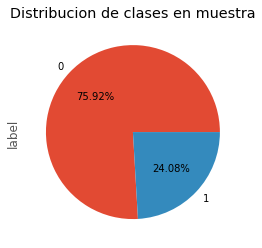

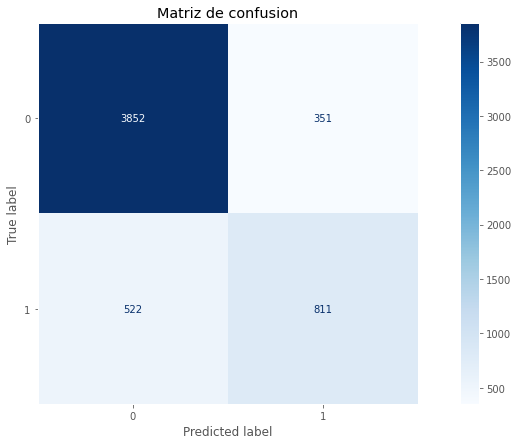

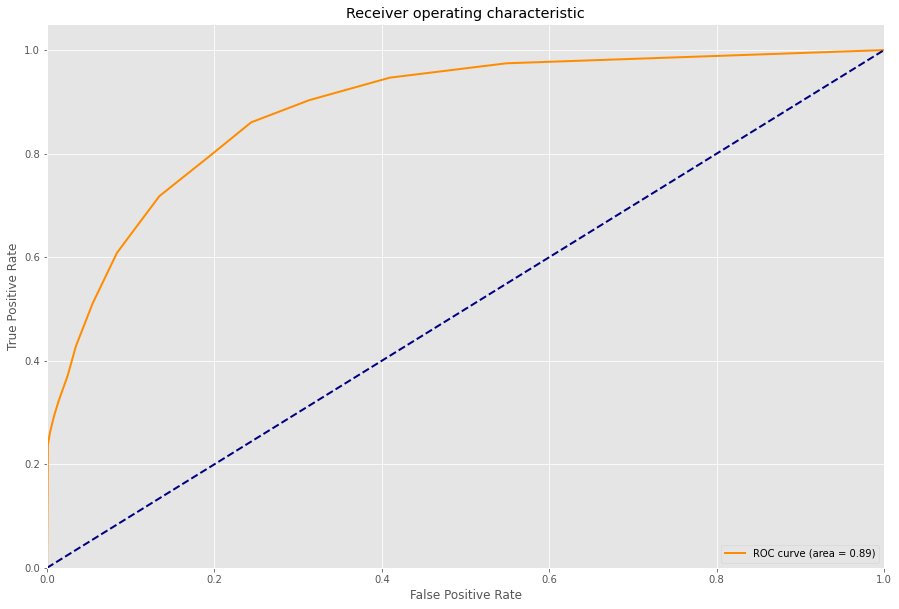

Métricas:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      4203
           1       0.70      0.61      0.65      1333

    accuracy                           0.84      5536
   macro avg       0.79      0.76      0.77      5536
weighted avg       0.84      0.84      0.84      5536



In [16]:
informe.imprimir_informe(modelo3, X_holdout_reducido, y_holdout)

### Conclusiones de las métricas observadas de los datos de hold_out

- accuracy:

        El modelo clasifica los datos de forma correcta en aproximadamente un 84%, viendo la distribucion de clases de la muestra se observa que los encuestados de bajos ingresos son la clase mayoritaria con una proporción de aproximadamente 76%. Por lo tanto el modelo es mejor predictor que devolver siempre cero.
    
    
- precisión:

        El porcentaje de predicciones de bajos ingresos que realmente lo eran fue de aproximadamente 88% y el porcentaje de predicciones de altos ingresos que realmente lo eran fue del 70% 


- recall:

        El porcentaje de bajos ingresos reales detectados fueron aproximadamente del 92%, y el de los altos ingresos reales detectados fueron del 61%.
       
       
- matriz de confusión:

        Se puede ver que las predicciones mayoritarias caen en la diagonal principal, lo cual es una buena caracteristica de una matriz de confusión.
        Aproximadamente el 84% de las instancias se encuentran en la diagonal principal, (lo cual ya sabiamos por el accuracy del 84%)
        
        
- AUC ROC:

        Esta métrica indica que el modelo es bueno distinguiendo clases con un score de 0.89. Este valor será utilizado para decidir sobre la elección de este modelo.



# Final test

In [13]:
df_test = informe.get_df_test()

#preprocesamiento
df_test = preprocessing.remove_irrelevant_features(df_test)
df_test = preprocessing.missings_treatment(df_test)
df_test = preprocessing.one_hot_encoding(df_test)
df_test = df_test[features_relevantes]

y_pred = modelo3.predict(df_test)
informe.save_pred(y_pred, 'knn')